In [1]:
# Retrieval is the process of fetching relevant information from an external data source (like a document database or vector store) to help a language model generate more accurate, grounded, and context-aware responses.
# Generation is the final step where a language model creates a response based on the user query and the documents retrieved from the knowledge base.

In [2]:
from dotenv import load_dotenv
load_dotenv() # load environment variables

True

### Problem Statement

**Retrieval** is a critical step in RAG pipelines. If the retriever fails to surface relevant documents, the **generation** stage will be starved of the context it needs — even if the answer exists somewhere in the data.

**Example:**

User query:
- “Can I bring my dog on the plane?”

Problem:
- The relevant document says: “Small pets are allowed in the cabin if kept in an airline-approved carrier.”
- The word “dog” never appears — only “pets” or “animals.”

Retrieval Failure:
- A naive retriever might not consider “dog” and “pet” semantically similar.
- The relevant document is not retrieved, even though it answers the question.

Result:
- The LLM, lacking the key passage, responds: “I couldn’t find any information about dogs on the plane.”
- Users perceive this as a model failure, but the real issue was the retriever’s blind spot.

### Strategy #1: Ranking

![Image](rsc/jupyter/rag-fusion.png)

**Idea**: Post-processing step where the initial set of retrieved documents is re-scored and re-ordered based on how relevant they are to the user’s query — typically using a more powerful model than was used during initial retrieval.

---

Three strategies that use this idea:
- **Re-Rank**: Score and reorder initially retrieved documents using a query-document relevance model (e.g., a cross-encoder).
- **RankGPT**: Use a language model itself to rank candidate documents by how well they answer the query — using generation and reasoning rather than embeddings.
- **RAG-Fusion**: Run multiple diverse queries (original + variations) through the retriever, then fuse the results for better coverage (we covered this in "query translation").

In [3]:
# Let's start by scraping and indexing some documents

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=OllamaEmbeddings(model="nomic-embed-text"))

retriever = vectorstore.as_retriever()
blog_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [4]:
# Setup RAG-Fusion query generation chain

from langchain.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

# RAG-Fusion
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_rag_fusion
    | ChatOllama(model="llama3.2:1b")
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

generate_queries

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are a helpful assistant that generates multiple search queries based on a single input query. \n\nGenerate multiple search queries related to: {question} \n\nOutput (4 queries):'), additional_kwargs={})])
| ChatOllama(model='llama3.2:1b')
| StrOutputParser()
| RunnableLambda(...)

In [26]:
# Same code as from RAG-Fusion. The idea is:
#   1. We generate multiple related queries from the input query.
#   2. We retrieve documents for each query.
#   3. We merge and rank all the documents, sorting them by their score.
#   4. During retrieval, we pass the list of sorted document-rank pairs to the LLM.

from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": "What is task decomposition for LLM agents?"})
len(docs)

24

In [6]:
# RAG with RAG-Fusion: We retrieve a list of sorted document-rank pairs for generation

from operator import itemgetter

# RAG template
template = """Answer the following question based on this context:

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | ChatOllama(model="llama3.2:1b")
    | StrOutputParser()
)

final_rag_chain.invoke({"question": "What is task decomposition for LLM agents?"})

'Task decomposition is a process used by LLM (Large Language Model) agents to break down complex tasks into smaller, manageable subtasks and generate multiple thoughts or steps to achieve each subtask. This technique involves identifying the key components of a task, such as subgoals or objectives, and then creating a tree-like structure to decompose the task into more manageable parts.'

### Strategy #2: CRAG

![Image](rsc/jupyter/crag.png)

**Idea**: The language model identifies and corrects retrieval errors during generation — essentially giving itself a second chance if the first retrieval step was inadequate.

---

Here, we'll implement a variant of CRAG following a simple rule:
- If any documents are irrelevant, we'll supplement retrieval with web search.

In [7]:
# Let's begin by indexing 3 blog posts

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Embedding
embedding = OllamaEmbeddings(model="nomic-embed-text")

# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

In [8]:
# Set up a retrieval grading chain (use later)
#   - Returns '1' if the document is relevant to the query
#   - Returns '0' otherwise

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model="llama3.2:1b", format="json")

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given:
    - a QUESTION
    - A FACT provided by the student

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION.
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION.
    1 is the highest (best) score. 0 is the lowest score you can give.

    Question: {question} \n
    Fact: \n\n {documents} \n\n

    Give a binary score 1 or 0 score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    """,
    input_variables=["question", "documents"],
)

# Test retrieval
question = "agent memory"
retrieval_grader = prompt | llm | JsonOutputParser()
docs = retriever.invoke(question)
doc_txt = docs[1].page_content

# Test grading
grade = retrieval_grader.invoke({"question": question, "documents": doc_txt})
doc_txt, grade

('Each element is an observation, an event directly provided by the agent.\n- Inter-agent communication can trigger new natural language statements.\n\n\nRetrieval model: surfaces the context to inform the agent’s behavior, according to relevance, recency and importance.\n\nRecency: recent events have higher scores\nImportance: distinguish mundane from core memories. Ask LM directly.\nRelevance: based on how related it is to the current situation / query.\n\n\nReflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are higher-level summaries of past events (<- note that this is a bit different from self-reflection above)\n\nPrompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: translate the reflections and the environment information into actions',
 {'score': 1})

In [9]:
# Set up a RAG chain (use later)

from langchain_core.output_parsers import StrOutputParser

# RAG Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)
llm = ChatOllama(model="llama3.2:1b")
rag_chain = prompt | llm | StrOutputParser()

# Test retrieval and generation
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

The question "agent memory" refers to the concept in artificial intelligence where an agent's knowledge and experiences are stored and retained over time. According to the documents provided, here is a concise answer:

 Agents' memories can be categorized into short-term (in-context learning) and long-term (external vector store) memory.

 Short-term memory: All in-context learning (See Prompt Engineering) is considered as utilizing short-term memory of the model to learn.
 Long-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.


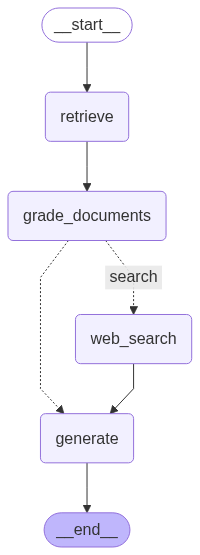

In [10]:
# Now, we use LangGraph to define the CRAG control flow.

# The basics of LangGraph are:
#   - State - A dictionary that holds variables and is passed from node to node.
#   - Nodes - Each node represents an action and is tied to a function.
#           - Nodes take the current state as input and output a list of updates to the state after they execute.
#           - START and END are special predefined nodes that mark the beginning and end of the graph execution.
#   - Edges - Edges connect nodes.
#           - After a node performs its action, it passes execution to connected nodes.
#   - Conditional Edges - A conditional edge is tied to a conditional function.
#                       - Given the current state, it determines which connected node to route execution to next.

from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langchain_tavily import TavilySearch
from langgraph.graph import START, END, StateGraph

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {
        "documents": documents,
        "question": question,
        "steps": steps
    }


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        print(f"Grade: {d.page_content[0:25]}...", "-->", grade)
        if grade == 1:
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = TavilySearch(max_results=3).invoke({"query": question})
    documents.extend(
        [
            Document(page_content=doc["content"], metadata={"url": doc["url"]})
            for doc in web_results['results']
        ]
    )
    return {
        "documents": documents,
        "question": question,
        "steps": steps
    }


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Everything's set up! We're expecting the system to:
#  - Retrieve documents
#  - Grade them
#  - If at least one is not relevant, search the web
#  - Generate a response given the context
#  - We can trace this flow in LangSmith (https://smith.langchain.com/)

# Let's run the CRAG graph on an input query that does NOT require web search.

import uuid

def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

query = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(query)
response

Grade: Comparison of AD, ED, sou... --> 1
Grade: Short-term memory: I woul... --> 1
Grade: They also discussed the r... --> 1
Grade: Short-Term Memory (STM) o... --> 0


{'response': 'Here are the answers to your questions based on the provided documents:\n\n1. What are the types of agent memory?\nThe document provides an overview of different types of agent memory, including:\n\n* Short-term memory (in-context learning)\n* Long-term memory (external vector store and fast retrieval)\n\n2. Which type of memory is considered a "short-term" memory in the context of the LLM-powered autonomous agent system?\nAll in-context learning (See Prompt Engineering) is considered short-term memory.\n\n3. What is the purpose of long-term memory in an LLM-powered autonomous agent system?\nLong-term memory provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

In [12]:
# Now, let's run on an input query that DOES require web search.

query = {"input": "What are the main types of dog breeds?"}
response = predict_custom_agent_local_answer(query)

response

Grade: Two main types of CoT pro... --> 1
Grade: Comparison of MIPS algori... --> 1
Grade: Comparison of AD, ED, sou... --> 1
Grade: Weng, Lilian. (Jun 2023).... --> 1


{'response': 'There are 6 main types of dog breeds mentioned in the provided documents:\n\n1. Sporting breeds, which typically include Retrievers and Spaniels.\n2. Working breeds, such as Corgis and German Shepherds.\n3. Hound breeds, including Beagles and Bloodhounds.\n4. Terrier breeds, like Yorkshire Terriers and Airedales.\n5. Toy breeds, like Chihuahuas and Poodles.\n\nThese breeds are mentioned in the documents under various sections such as "CoT prompting," "Agent System Overview," "Memory" (in three separate sections), and "Tool use."',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

### Strategy #3: Self-RAG

![Image](rsc/jupyter/self-rag.png)

**Idea**: The language model itself actively critiques and improves its own retrieval process, often by reformulating the query, selecting better documents, or rerunning retrieval — all within a single inference loop.

In [13]:
# Let's begin by indexing 3 blog posts (again)

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OllamaEmbeddings(model="nomic-embed-text"),
)
retriever = vectorstore.as_retriever()

In [14]:
### RAG Generation Chain

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOllama(model="llama3.2:1b")

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Based on the provided text, I'll analyze it to identify a specific topic or question.

The text appears to be a research paper or academic article discussing various methods and techniques for detecting and mitigating adversarial attacks on language models (LLMs). The title "Adversarial Attacks on LLMs" suggests that the topic is related to natural language processing (NLP) security.

Some specific sections mentioned in the text include:

1. **Adversarial training**: A technique used to train LLMs to be more robust against attacks, but also discusses potential trade-offs between robustness and model performance.
2. **Universal Adversarial Triggers (UAT)**: An approach for generating adversarial examples that can be used as prompts to attack LLMs.
3. **White-box attacks**: Techniques for detecting and mitigating white-box attacks on LLMs, where the attacker has direct access to the model's internal workings.

To identify a specific question or topic within this paper, I'll analyze some 

In [25]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model="llama3.2:1b", format="json")

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n

    Here is the retrieved document:
    \n ------- \n
    {document}
    \n ------- \n

    Here is the user question: {question} \n

    If the document contains keywords related to the user question, grade it as relevant.
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
    Give a binary score 1 or 0 score to indicate whether the document is relevant to the question.
        - 1 indicates that the document is relevant to the question.
        - 0 indicates that the document is NOT relevant to the question.

    Provide the binary score (1 or 0) as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content

retrieval_grader.invoke({"question": question, "document": doc_txt})

{'score': 1}

In [16]:
### Hallucination Grader

# LLM
llm = ChatOllama(model="llama3.2:1b", format="json")

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n

    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n

    Here is the answer: {generation}

    Give a binary score 1 or 0 score to indicate whether the answer is grounded in / supported by the set of facts.
        - 1 indicates that the answer is supported by the facts.
        - 0 indicates that the answer is NOT supported by the facts.

    Provide the binary score (1 or 0) as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 1}

In [17]:
### Answer Grader

# LLM
llm = ChatOllama(model="llama3.2:1b", format="json")

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n

    Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n

    Here is the question: {question}

    Give a binary score 1 or 0 to indicate whether the answer is useful to resolve a question.
        - 1 indicates that the answer is useful to resolve a question.
        - 0 indicates that the answer is NOT useful to resolve a question.

    Provide the binary score (1 or 0) as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 1}

In [18]:
### Question Re-writer

# LLM
llm = ChatOllama(model="llama3.2:1b")

# Prompt
re_write_prompt = PromptTemplate(
    template="""You are a question re-writer that converts an input question to a better version that is optimized
        for vectorstore retrieval. Look at the initial question and formulate an improved question.

        Rules:
            - Don't add any preamble or explanation to the improved question.
            - Don't add quotations around the improved question.
            - Don't talk about yourself in the improved question.
            - Just write the improved question.

        Here is the initial question: {question}.

        Improved question with no preamble or explanation:""",
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
print(question_rewriter.invoke({"question": question}))

What are the data structures used to store and retrieve information in an artificial intelligence system's memory?


In [19]:
# Define Graph State

from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

In [20]:
### Define Nodes

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    print("Generation:", generation)
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == 1:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [21]:
### Define Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == 1:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == 1:
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [22]:
# Build the graph

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [24]:
# Let's run the Self-RAG graph on a query

inputs = {"question": "Explain how the different types of agent memory work?"}
output = {}
for output in app.stream(inputs):
    for key, value in output.items():
        output = value

# Final generation
output["generation"]

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
Generation: The different types of agent memory work as follows:

- **Short-term memory**: Utilizes in-context learning, short-term memory of the model to learn.
- **Long-term memory**: Retains and recalls information over extended periods through an external vector store and fast retrieval.

Additionally, planning components involve breaking down large tasks into smaller subgoals for efficient handling.
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT 

'The mechanisms used to store and manage agent memory in an LLM-powered autonomous agent system include short-term and long-term memory, as well as external vector stores. Short-term memory is utilized through "in-context learning," which leverages the model\'s weights for context-aware learning. Long-term memory is supported by an external vector store and fast retrieval capabilities.'